# Olist E‑commerce: End‑to‑End Business Analysis
**By:** Aarohi Mistry  
**GitHub:** [AarohiAnalyzes/olist-ecommerce-analysis](https://github.com/AarohiAnalyzes/olist-ecommerce-analysis)  
**Dataset:** Brazilian E‑Commerce by Olist (Kaggle)

## Project Overview
Comprehensive analysis of Brazilian e-commerce data covering three business domains.

## Project Objectives
1. **Sales Performance** – Monthly revenue trends (2017‑2018)  
2. **Customer Geographic Analysis** – Regional distribution  
3. **Product & Seller Performance** – Category insights, seller efficiency


---
## **Question 1: Sales Performance Analysis**
**Business Question:** What was the monthly revenue for delivered orders in 2017 and 2018?

**Analysis Plan:**
1. Load orders and `order_items` data  
2. Join tables on `order_id`  
3. Filter for delivered orders  
4. Calculate revenue (`price` – no quantity column)  
5. Extract year‑month from timestamp  
6. Aggregate monthly revenue  
7. Visualize trends
---

## 1.0 Initial Setup for the Project

In [211]:
# Import Libraries for data analysis and data visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All the libraries imported successfully...")

All the libraries imported successfully...


In [212]:
# Load the datasets
order_items_df = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
order_df = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")

print("Datasets are loaded...")

Datasets are loaded...


In [213]:
order_items_df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [214]:
order_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')


* From `order_items_df` -> Select `order_id`, `price`, `product_id`, `seller_id`
* From `order_df` -> Select `order_id`, `order_purchase_timestamp`, `order_status`,`customer_id` 


In [215]:
# selecting required columns from both the dfs using .loc function
order_new = order_df.loc[:,['order_id', 'order_purchase_timestamp', 'order_status','customer_id']]
order_new.columns

Index(['order_id', 'order_purchase_timestamp', 'order_status', 'customer_id'], dtype='object')

In [216]:
order_items_new = order_items_df.loc[:,['order_id', 'price', 'product_id', 'seller_id']]
order_items_new.columns

Index(['order_id', 'price', 'product_id', 'seller_id'], dtype='object')

## 1.1 `order` VS. `order_items` analysis

In [217]:
# Basic Shape Information
print("Orders shape:", order_new.shape)
print("Order items shape:", order_items_new.shape)

print("-------------------------------")

# Average Order items per order
avg_item_per_order = order_items_new.shape[0] / order_new.shape[0]
print(f"Average items per order: {avg_item_per_order:.2f}")

# Check for order uniqueness
unique_orders = order_new['order_id'].nunique()
duplicate_orders = order_new.shape[0] - unique_orders

print("-------------------------------")

print("Number of unique orders:",unique_orders)
print("Number of duplicate orders:",duplicate_orders)

print("-------------------------------")

# Check how many orders have items
order_with_items = order_items_new['order_id'].nunique()
order_without_items = order_new.shape[0] - order_with_items
print("Number of orders with items:", order_with_items)
print("Number of orders without items:", order_without_items)

print("-------------------------------")

# Item distribution per order (Using Groupby)

items_per_order = order_items_new.groupby('order_id').size()
print("Minimum number of items per order:",items_per_order.min())
print("Maximum number of items per order:",items_per_order.max())

print("-------------------------------")

print("Sample Data for Orders")
print(order_new.sample(3))
print("\n")
print("Sample Data for Order Items")
print(order_items_new.sample(3))

Orders shape: (99441, 4)
Order items shape: (112650, 4)
-------------------------------
Average items per order: 1.13
-------------------------------
Number of unique orders: 99441
Number of duplicate orders: 0
-------------------------------
Number of orders with items: 98666
Number of orders without items: 775
-------------------------------
Minimum number of items per order: 1
Maximum number of items per order: 21
-------------------------------
Sample Data for Orders
                               order_id order_purchase_timestamp order_status  \
1110   31570df15e703d337b7b8a1d1ddcab6b      2017-10-20 14:00:10    delivered   
61592  5471d5c0cbff5d04724a56e49cd4d308      2018-07-18 17:53:55    delivered   
88301  8ae8b33f63d9924a2db9ec6c1e98fd35      2017-04-03 14:04:19    delivered   

                            customer_id  
1110   f94b42a1fbdacb6be65b3f64cd68ce5f  
61592  a6d538e158ddb434374047d413315beb  
88301  185830935eb09d19b034abbab645177c  


Sample Data for Order Items
 

#### 1.1 Summary: Orders vs. Order Items
- **Total orders:** 99,441 | **Total items:** 112,650  
- **Avg items per order:** 1.13 → *Single‑item marketplace*  
- **Orders without items:** 775 (0.78%) – *failed/cancelled orders*  
- **Bulk purchases:** up to 21 items in one order → *B2B potential*  
- **Data quality:** No duplicate order IDs

**Business decision:** Exclude the 775 orders without items from revenue analysis.

## 1.2 Date Range Analysis

In [218]:
order_new.columns

Index(['order_id', 'order_purchase_timestamp', 'order_status', 'customer_id'], dtype='object')

In [219]:
order_items_new.columns

Index(['order_id', 'price', 'product_id', 'seller_id'], dtype='object')

In [220]:
# Convert datatype from 'object' to 'datetime'
order_new['order_purchase_timestamp'] = pd.to_datetime(order_new['order_purchase_timestamp'], errors="coerce")
print(order_new['order_purchase_timestamp'].dtype)

datetime64[ns]


In [221]:
# Count of missing values in the 'order_purchase_timestamp' column
order_new["order_purchase_timestamp"].isnull().sum()

np.int64(0)

In [222]:
# Min Date
order_new['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

In [223]:
# Max Date
order_new['order_purchase_timestamp'].max()

Timestamp('2018-10-17 17:30:18')

In [224]:
order_new.head()

,order_id,order_purchase_timestamp,order_status,customer_id
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,delivered,9ef432eb6251297304e76186b10a928d
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,delivered,b0830fb4747a6c6d20dea0b8c802d7ef
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,delivered,41ce2a54c0b03bf3443c3d931a367089
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,delivered,f88197465ea7920adcdbec7375364d82
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,delivered,8ab97904e6daea8866dbdbc4fb7aad2c


In [225]:
# Create a new column "year_month" and extract year and month as a string "YYYY-MM"
order_new['year_month'] = order_new["order_purchase_timestamp"].dt.strftime('%Y-%m')
order_new.head()

,order_id,order_purchase_timestamp,order_status,customer_id,year_month
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,delivered,9ef432eb6251297304e76186b10a928d,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,delivered,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,delivered,41ce2a54c0b03bf3443c3d931a367089,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,delivered,f88197465ea7920adcdbec7375364d82,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,delivered,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02


In [226]:
# Sort the values according to date and time
order_new = order_new.sort_values('order_purchase_timestamp').reset_index(drop=True)
order_new.head()

,order_id,order_purchase_timestamp,order_status,customer_id,year_month
0,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04 21:15:19,shipped,08c5351a6aca1c1589a38f244edeee9d,2016-09
1,e5fa5a7210941f7d56d0208e4e071d35,2016-09-05 00:15:34,canceled,683c54fc24d40ee9f8a6fc179fd9856c,2016-09
2,809a282bbd5dbcabb6f2f724fca862ec,2016-09-13 15:24:19,canceled,622e13439d6b5a0b486c435618b2679e,2016-09
3,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,delivered,86dc2ffce2dfff336de2f386a786e574,2016-09
4,71303d7e93b399f5bcd537d124c0bcfa,2016-10-02 22:07:52,canceled,b106b360fe2ef8849fbbd056f777b4d5,2016-10


In [227]:
# Monthly order counts
order_new.groupby('year_month').size()

year_month
2016-09       4
2016-10     324
2016-12       1
2017-01     800
2017-02    1780
2017-03    2682
2017-04    2404
2017-05    3700
2017-06    3245
2017-07    4026
2017-08    4331
2017-09    4285
2017-10    4631
2017-11    7544
2017-12    5673
2018-01    7269
2018-02    6728
2018-03    7211
2018-04    6939
2018-05    6873
2018-06    6167
2018-07    6292
2018-08    6512
2018-09      16
2018-10       4
dtype: int64

In [228]:
# Minimum monthly order counts
print(order_new.groupby('year_month').size().min())
print(order_new.groupby('year_month').size().idxmin())

1
2016-12


In [229]:
# Maximum monthly Order counts
print(order_new.groupby('year_month').size().max())
print(order_new.groupby('year_month').size().idxmax())

7544
2017-11


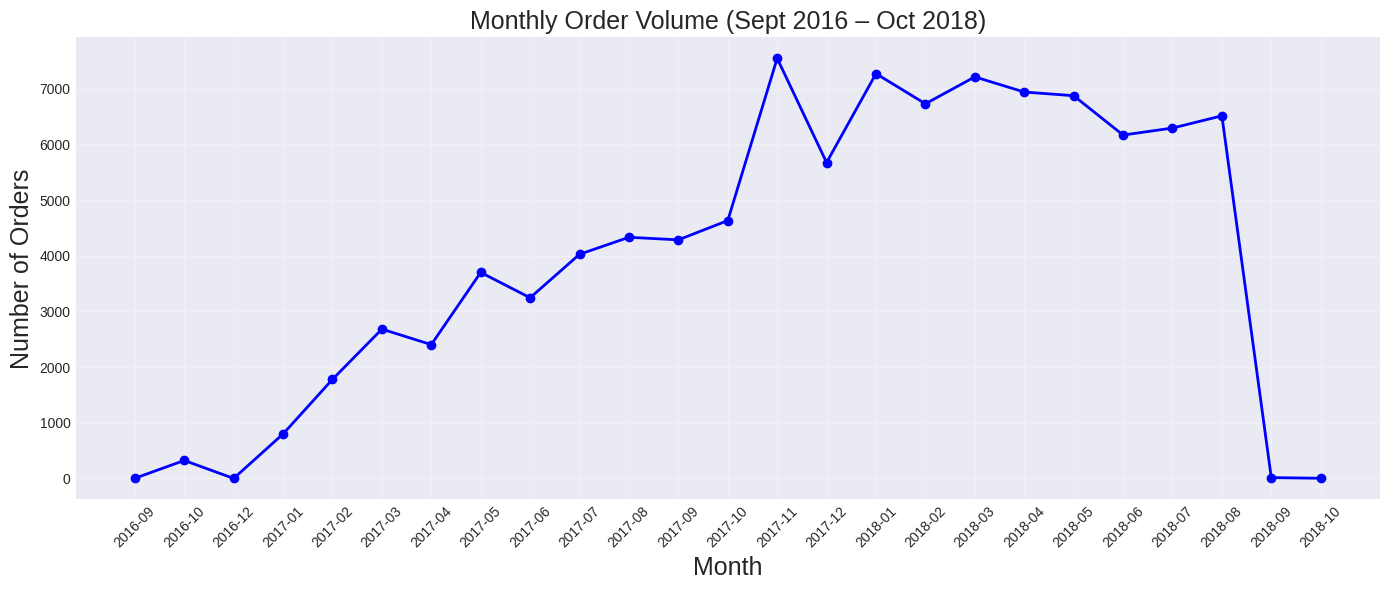

In [230]:
# Visualization for montly orders
import matplotlib.pyplot as plt

monthly_orders = order_new.groupby('year_month').size()

plt.figure(figsize=(14,6))
monthly_orders.plot(kind='line', marker='o', linewidth=2, color = 'Blue')
plt.title('Monthly Order Volume (Sept 2016 – Oct 2018)', fontsize=18)
plt.xlabel('Month', fontsize = 18)
plt.ylabel('Number of Orders', fontsize = 18)
plt.xticks(range(len(monthly_orders)), monthly_orders.index, rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [231]:
order_new['year'] = order_new['order_purchase_timestamp'].dt.strftime('%Y')
order_new['month'] = order_new['order_purchase_timestamp'].dt.strftime('%m')
order_new.head()

,order_id,order_purchase_timestamp,order_status,customer_id,year_month,year,month
0,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04 21:15:19,shipped,08c5351a6aca1c1589a38f244edeee9d,2016-09,2016,09
1,e5fa5a7210941f7d56d0208e4e071d35,2016-09-05 00:15:34,canceled,683c54fc24d40ee9f8a6fc179fd9856c,2016-09,2016,09
2,809a282bbd5dbcabb6f2f724fca862ec,2016-09-13 15:24:19,canceled,622e13439d6b5a0b486c435618b2679e,2016-09,2016,09
3,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,delivered,86dc2ffce2dfff336de2f386a786e574,2016-09,2016,09
4,71303d7e93b399f5bcd537d124c0bcfa,2016-10-02 22:07:52,canceled,b106b360fe2ef8849fbbd056f777b4d5,2016-10,2016,10


In [232]:
year_grpby = order_new.groupby('year').size()
print(year_grpby)

year
2016      329
2017    45101
2018    54011
dtype: int64


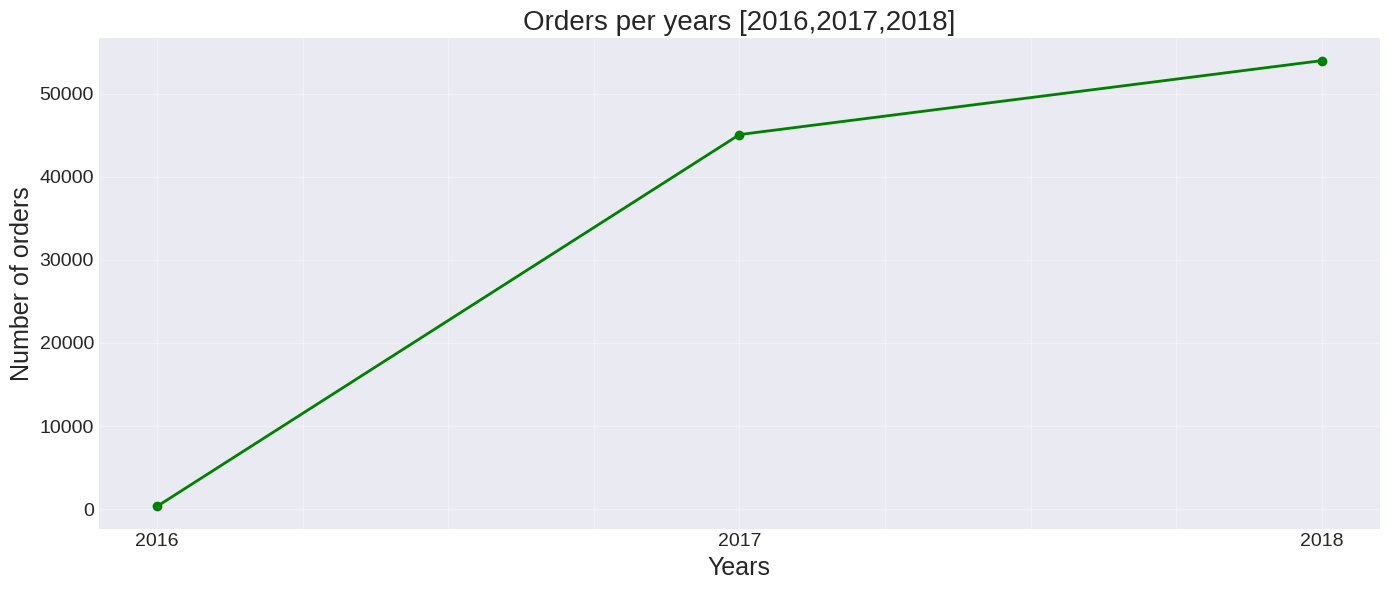

In [233]:
# Line chart showing the number of orders in the given three years

plt.figure(figsize = (14,6))
year_grpby.plot(kind='line', marker = 'o', linewidth = 2, color = 'green')

plt.title("Orders per years [2016,2017,2018]", fontsize = 20)
plt.xlabel("Years", fontsize = 18)
plt.ylabel("Number of orders", fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()

#### 1.2 Date Range Summary

- **Time coverage:** 2016-09-04 to 2018-10-17 (≈25 months).
- **Missing timestamps:** 0 – clean data.
- **Monthly order trend:**  
  - Orders grow steadily from early 2017, peak in **November 2017** (7,544 orders).  
  - Sharp drop in December 2017, then recovery in 2018.  
  - Data for **Sept–Dec 2016** and **Sept–Oct 2018** are sparse – these months will be excluded from full-year analysis.

**Decision:** For revenue analysis, I will **filter to full calendar years 2017 and 2018** only, to ensure fair month-to-month comparison.

## 1.3 Order Status Distrubution

In [234]:
order_new.columns

Index(['order_id', 'order_purchase_timestamp', 'order_status', 'customer_id',
       'year_month', 'year', 'month'],
      dtype='object')

In [235]:
# Frequency Counts
order_status_counts = order_new['order_status'].value_counts()
print(order_new['order_status'].value_counts())

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


In [236]:
# Convert the counts into percentage
print(round(order_new['order_status'].value_counts(normalize = True)*100,2))

order_status
delivered      97.02
shipped         1.11
canceled        0.63
unavailable     0.61
invoiced        0.32
processing      0.30
created         0.01
approved        0.00
Name: proportion, dtype: float64


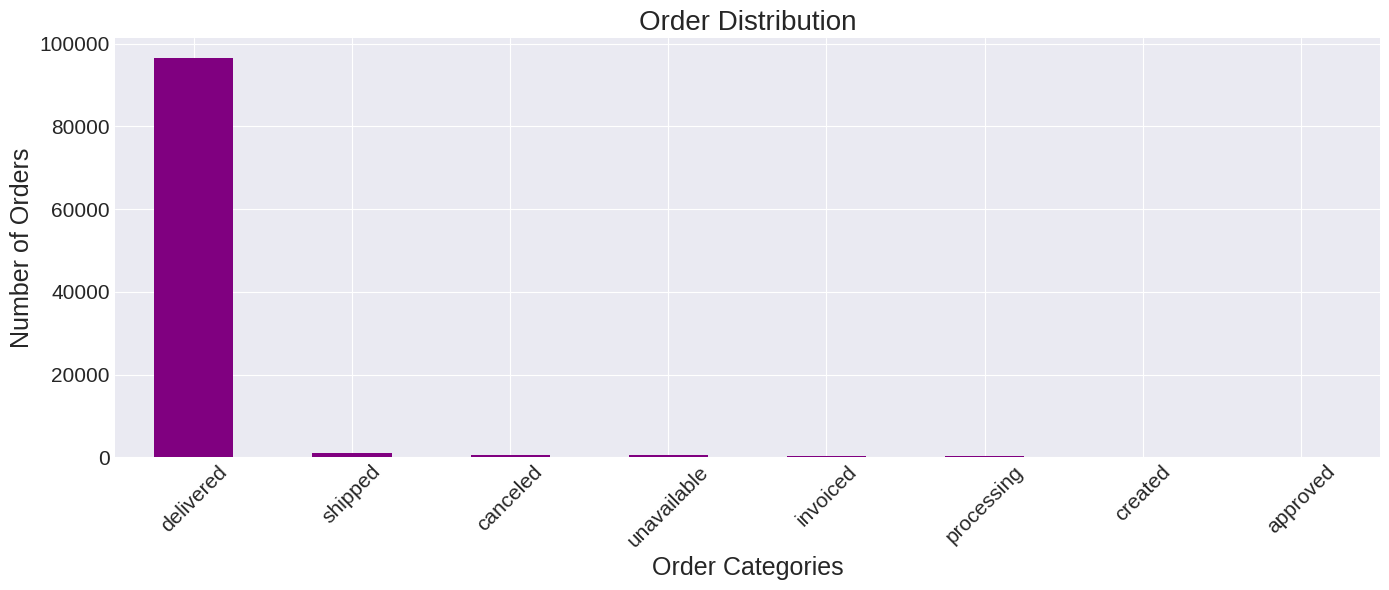

In [237]:
# Bar chart to see the distribution of the orders
plt.figure(figsize = (14,6))
order_status_counts.plot(kind="bar", color = 'purple')
plt.title("Order Distribution", fontsize = 20)
plt.xlabel("Order Categories", fontsize = 18)
plt.ylabel("Number of Orders", fontsize = 18)
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.show()

#### 1.3 Summary: Order Status Distribution

- **Delivered orders:** 96,478 (97.02% of orders with items)  
- **Shipped orders:** 1,107 (1.11%)
- **Canceled:** 625 (0.63%)  
- **Unavailable:** 609 (0.61%)  
- **Other statuses (invoiced, processing, created, approved):** < 0.7% combined  
- **Data quality:** No unexpected statuses; `delivered` is overwhelmingly dominant.

**Business decision:**  
Only **`delivered`** orders will be included in revenue calculation.  
All other statuses represent orders that either failed, were cancelled, or are not yet complete – they do not reflect actual earned revenue and will be **excluded** from the sales analysis.

## 1.4 Missing Values Analysis

In [238]:
print("Missing Values in the 'Order' table")
print(order_new.isnull().sum())
print("\n")
print("Missing Values in the 'Order_items' table")
print(order_items_new.isnull().sum())

Missing Values in the 'Order' table
order_id                    0
order_purchase_timestamp    0
order_status                0
customer_id                 0
year_month                  0
year                        0
month                       0
dtype: int64


Missing Values in the 'Order_items' table
order_id      0
price         0
product_id    0
seller_id     0
dtype: int64


#### 1.4 Summary: Missing Values Analysis

- **`order_new`:** 0 missing in all columns   
- **`order_items_new`:** 0 missing in `order_id` and `price`  
- **Critical columns:** `order_purchase_timestamp`, `order_status`, `price` – all complete.

**Decision:** No missing data to handle. The dataset is clean and ready for the next steps.  
This confirms that revenue calculations can proceed without imputation or row removal due to nulls.

## 1.5 Price Distribution & Outlier Analysis

In [239]:
# Descriptive Stats
print(order_items_new['price'].describe())

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64


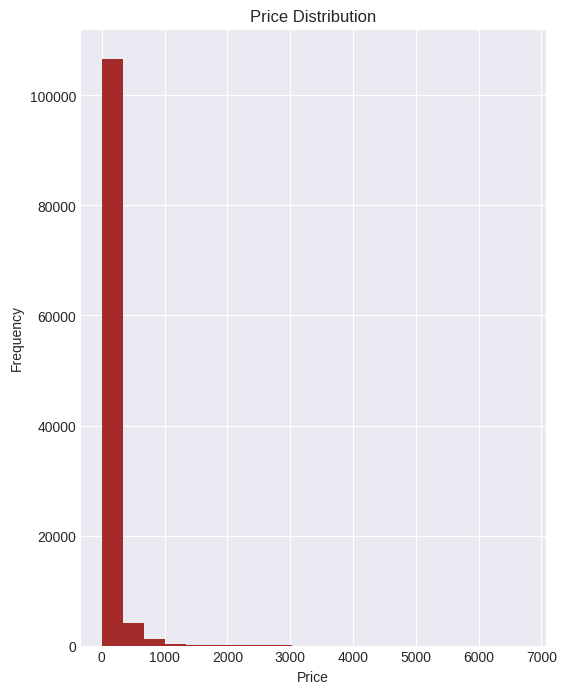

In [240]:
# Histogram to see the price distribution
plt.figure(figsize=(6, 8))
plt.hist(order_items_new["price"], bins=20, color = "brown")
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")

plt.show()

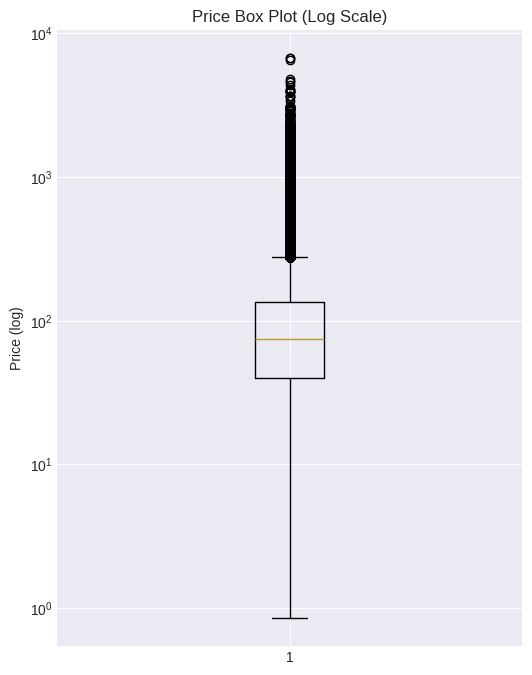

In [241]:
# Box plot for outliers
plt.figure(figsize=(6, 8))

plt.boxplot(order_items_new["price"])
plt.yscale("log")

plt.title("Price Box Plot (Log Scale)")
plt.ylabel("Price (log)")

plt.show()

In [242]:
# Looking for outliers manually
price = order_items_new["price"]

Q1 = price.quantile(0.25)
Q3 = price.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

Q1: 39.9
Q3: 134.9
IQR: 95.0
Lower Bound: -102.6
Upper Bound: 277.4


In [243]:
outliers = order_items_new[(order_items_new['price'] < lower_bound) | (order_items_new['price'] > upper_bound)]
print(len(outliers))

8427


In [244]:
lower_outliers = price[price < lower_bound]
upper_outliers = price[price > upper_bound]

print("Lower Outliers:", len(lower_outliers))
print("Upper Outliers:", len(upper_outliers))


Lower Outliers: 0
Upper Outliers: 8427


In [245]:
percent_outliers = round((len(outliers) / len(price)) * 100,2)
print("Outlier Percentage:", percent_outliers, "%")

Outlier Percentage: 7.48 %


In [246]:
# Top 10 Highest Prices
order_items_new['price'].nlargest(10).reset_index(drop=True)

0    6735.00
1    6729.00
2    6499.00
3    4799.00
4    4690.00
5    4590.00
6    4399.87
7    4099.99
8    4059.00
9    3999.90
Name: price, dtype: float64

#### 1.5 Summary: Price Distribution & Outliers

- **Price range:** 0.85 to 6,735.00  
- **Median price:** 74.99 | **Mean price:** 120.65  
- **Distribution:** Strong right skew – most items are inexpensive, a small number are high‑value.  
- **Outliers (IQR method):**  
  - **Upper outliers:** 8,427 items (7.48% of total) – prices above 277.40  
  - **Lower outliers:** 0 items  

**Business decision:**  
All prices appear legitimate. Outliers represent genuine high‑value sales.  
Therefore, **no capping or removal will be applied** – all prices will be kept as‑is for revenue calculation.

## 1.6 Revenue Calculation & Monthly Trend (2017–2018)

In [247]:
# Filter Orders
delivered_orders = order_new[order_new['order_status'] == 'delivered']
print(delivered_orders.columns)
print("\n")
print(delivered_orders.head().reset_index(drop = True))

Index(['order_id', 'order_purchase_timestamp', 'order_status', 'customer_id',
       'year_month', 'year', 'month'],
      dtype='object')


                           order_id order_purchase_timestamp order_status  \
0  bfbd0f9bdef84302105ad712db648a6c      2016-09-15 12:16:38    delivered   
1  3b697a20d9e427646d92567910af6d57      2016-10-03 09:44:50    delivered   
2  be5bc2f0da14d8071e2d45451ad119d9      2016-10-03 16:56:50    delivered   
3  a41c8759fbe7aab36ea07e038b2d4465      2016-10-03 21:13:36    delivered   
4  d207cc272675637bfed0062edffd0818      2016-10-03 22:06:03    delivered   

                        customer_id year_month  year month  
0  86dc2ffce2dfff336de2f386a786e574    2016-09  2016    09  
1  355077684019f7f60a031656bd7262b8    2016-10  2016    10  
2  7ec40b22510fdbea1b08921dd39e63d8    2016-10  2016    10  
3  6f989332712d3222b6571b1cf5b835ce    2016-10  2016    10  
4  b8cf418e97ae795672d326288dfab7a7    2016-10  2016    10  


In [248]:
order_items_new.columns

Index(['order_id', 'price', 'product_id', 'seller_id'], dtype='object')

In [249]:
# Merge the two tables : delivered_orders and order_items_new
merged_tables = pd.merge(delivered_orders, order_items_new, on = 'order_id', how = 'inner')
print(merged_tables.head().reset_index(drop=True))
print("\n")
print("The shape of the merged tables:", merged_tables.shape)

                           order_id order_purchase_timestamp order_status  \
0  bfbd0f9bdef84302105ad712db648a6c      2016-09-15 12:16:38    delivered   
1  bfbd0f9bdef84302105ad712db648a6c      2016-09-15 12:16:38    delivered   
2  bfbd0f9bdef84302105ad712db648a6c      2016-09-15 12:16:38    delivered   
3  3b697a20d9e427646d92567910af6d57      2016-10-03 09:44:50    delivered   
4  be5bc2f0da14d8071e2d45451ad119d9      2016-10-03 16:56:50    delivered   

                        customer_id year_month  year month  price  \
0  86dc2ffce2dfff336de2f386a786e574    2016-09  2016    09  44.99   
1  86dc2ffce2dfff336de2f386a786e574    2016-09  2016    09  44.99   
2  86dc2ffce2dfff336de2f386a786e574    2016-09  2016    09  44.99   
3  355077684019f7f60a031656bd7262b8    2016-10  2016    10  29.90   
4  7ec40b22510fdbea1b08921dd39e63d8    2016-10  2016    10  21.90   

                         product_id                         seller_id  
0  5a6b04657a4c5ee34285d1e4619a96b4  ecccfa2bb93b3

In [250]:
# Renaming the col 'Price' to 'revenue'
merged_tables = merged_tables.rename(columns = {'price':'revenue'})
print(merged_tables.columns)

Index(['order_id', 'order_purchase_timestamp', 'order_status', 'customer_id',
       'year_month', 'year', 'month', 'revenue', 'product_id', 'seller_id'],
      dtype='object')


In [251]:
# Aggregate Monthly revenue
results = merged_tables.groupby('year_month', as_index = False)['revenue'].sum()
print(results)

   year_month    revenue
0     2016-09     134.97
1     2016-10   40325.11
2     2016-12      10.90
3     2017-01  111798.36
4     2017-02  234223.40
5     2017-03  359198.85
6     2017-04  340669.68
7     2017-05  489338.25
8     2017-06  421923.37
9     2017-07  481604.52
10    2017-08  554699.70
11    2017-09  607399.67
12    2017-10  648247.65
13    2017-11  987765.37
14    2017-12  726033.19
15    2018-01  924645.00
16    2018-02  826437.13
17    2018-03  953356.25
18    2018-04  973534.09
19    2018-05  977544.69
20    2018-06  856077.86
21    2018-07  867953.46
22    2018-08  838576.64


In [252]:
# Sort the results
results = results.sort_values('year_month')
print(results)

   year_month    revenue
0     2016-09     134.97
1     2016-10   40325.11
2     2016-12      10.90
3     2017-01  111798.36
4     2017-02  234223.40
5     2017-03  359198.85
6     2017-04  340669.68
7     2017-05  489338.25
8     2017-06  421923.37
9     2017-07  481604.52
10    2017-08  554699.70
11    2017-09  607399.67
12    2017-10  648247.65
13    2017-11  987765.37
14    2017-12  726033.19
15    2018-01  924645.00
16    2018-02  826437.13
17    2018-03  953356.25
18    2018-04  973534.09
19    2018-05  977544.69
20    2018-06  856077.86
21    2018-07  867953.46
22    2018-08  838576.64


**Note:** The dataset contains a small number of orders in late 2016 (Sept, Oct, Dec).  
These represent the platform's early launch phase and are excluded from the main trend analysis to avoid distortion.  
The core analysis covers **20 complete months from January 2017 to August 2018**.

In [253]:
# Filter to 2017–2018
monthly_revenue_2017_2018 = results[results['year_month'].str.startswith(('2017', '2018'))]
print(monthly_revenue_2017_2018.reset_index(drop=True))

   year_month    revenue
0     2017-01  111798.36
1     2017-02  234223.40
2     2017-03  359198.85
3     2017-04  340669.68
4     2017-05  489338.25
5     2017-06  421923.37
6     2017-07  481604.52
7     2017-08  554699.70
8     2017-09  607399.67
9     2017-10  648247.65
10    2017-11  987765.37
11    2017-12  726033.19
12    2018-01  924645.00
13    2018-02  826437.13
14    2018-03  953356.25
15    2018-04  973534.09
16    2018-05  977544.69
17    2018-06  856077.86
18    2018-07  867953.46
19    2018-08  838576.64


In [254]:
# Total Revenue
print(round(monthly_revenue_2017_2018['revenue'].sum(),2))

13181027.13


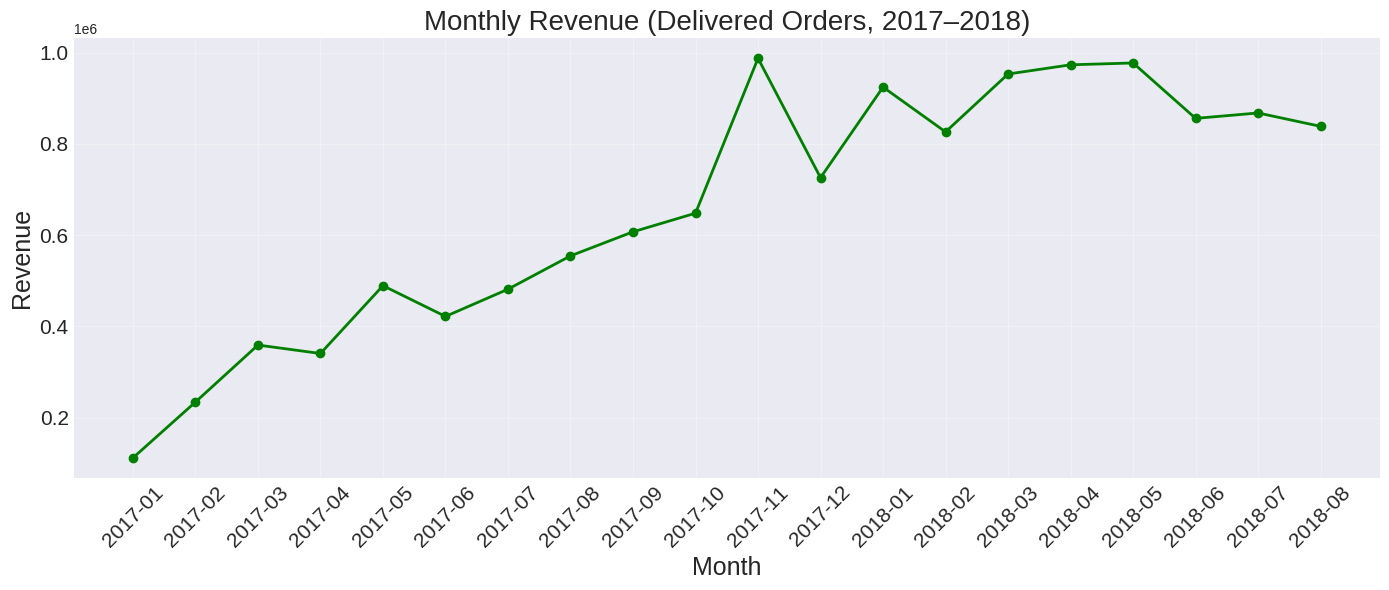

In [255]:
plt.figure(figsize=(14,6))
plt.plot(monthly_revenue_2017_2018['year_month'], monthly_revenue_2017_2018['revenue'], marker='o', linewidth=2, color='green')
plt.title('Monthly Revenue (Delivered Orders, 2017–2018)', fontsize=20)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Revenue', fontsize=18)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1.7 KPIs Analysis

In [256]:
# Total revenue
total_revenue = monthly_revenue_2017_2018['revenue'].sum()

# Best month
best_idx = monthly_revenue_2017_2018['revenue'].idxmax()
best_month = monthly_revenue_2017_2018.loc[best_idx, 'year_month']
best_revenue = monthly_revenue_2017_2018.loc[best_idx, 'revenue']

# Worst month (among these 20)
worst_idx = monthly_revenue_2017_2018['revenue'].idxmin()
worst_month = monthly_revenue_2017_2018.loc[worst_idx, 'year_month']
worst_revenue = monthly_revenue_2017_2018.loc[worst_idx, 'revenue']

print(f"Analysis period: Jan 2017 – Aug 2018 (20 months)")
print(f"Total revenue: R${total_revenue:,.2f}")
print(f"Best month: {best_month} – R${best_revenue:,.2f}")
print(f"Worst full month: {worst_month} – R${worst_revenue:,.2f}")

Analysis period: Jan 2017 – Aug 2018 (20 months)
Total revenue: R$13,181,027.13
Best month: 2017-11 – R$987,765.37
Worst full month: 2017-01 – R$111,798.36


#### 1.6 & 1.7 Summary: Revenue Performance & KPI Analysis (Jan 2017 – Aug 2018)

**Analysis scope:** 20 complete months of delivered orders, from **January 2017 to August 2018**.  
*Months before 2017(platform launch phase) and Sept-Oct 2018 were excluded due to very low order volume. Nov-Dec 2018 data is not available in the dataset.*

| Metric | Value |
|--------|-------|
| **Total revenue** | 13,181,027.13 |
| **Best month** | November 2017 – 987,765.37 |
| **Worst full month** | January 2017 – 111,798.36 |

**Revenue trends:**
- Steady growth throughout 2017, with a **sharp peak in November 2017** – consistent with Black Friday promotions.
- December shows a noticeable dip, followed by a strong recovery in early 2018.
- Revenue remained consistently high from January to August 2018.

**Business insights & recommendations:**
1. **Black Friday drives massive revenue** – consider extending similar promotional campaigns to other months (e.g., mid‑year sales).
2. **The December dip warrants investigation** – is it seasonal, or were there specific operational issues?
3. **Strong 2018 performance** suggests successful customer retention; explore what changed after December 2017.
4. **Data limitation:** 2018 data ends in October; full‑year 2018 revenue would likely be even higher.

**Next step:** Proceed to **Question 2 – Customer Geographic Analysis** to understand where these customers are located.

---
## **Question 2: Customer Geographic Analysis**

**Business Question:** What is the geographic distribution of Olist's customers, and how does revenue vary across Brazilian states?

**Analysis Plan:**
1. Load `customers` and `geolocation` datasets
2. Explore customer data (unique customers, states, cities)
3. Link customers to orders (delivered, 2017–2018)
4. Calculate **number of customers per state**
5. Calculate **total revenue per state** (by joining order items)
6. Visualise results (bar charts)
7. Identify top states and draw business insights
---

### 2.1 Customers Dataset Overview

In [257]:
customer_df = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")
customer_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [258]:
print(customer_df.shape)
print(customer_df.columns)

(99441, 5)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


In [259]:
# Check for missing values in the customers dataset
print(customer_df.isnull().sum())

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64


In [260]:
# Num of Unique States
customer_df['customer_state'].nunique()

27

In [261]:
# Unique states names
customer_df['customer_state'].unique()

array(['SP', 'SC', 'MG', 'PR', 'RJ', 'RS', 'PA', 'GO', 'ES', 'BA', 'MA',
       'MS', 'CE', 'DF', 'RN', 'PE', 'MT', 'AM', 'AP', 'AL', 'RO', 'PB',
       'TO', 'PI', 'AC', 'SE', 'RR'], dtype=object)

### 2.1 Summary: Customers Dataset Overview
- **Total customers:** 99441
- **Columns:** `customer_id`, `customer_unique_id`, `customer_zip_code_prefix`,
       `customer_city`, `customer_state`
- **Missing values:** 0 
- **Unique states:**  27 

## 2.2 Orders Linked to Customer Locations


* We already have our filtered Dataset `delivered_orders` that contains the details of the only orders that are delivered.
* We will combine that dataset with out customer_df on the `customer_id` column.


In [262]:
print(delivered_orders.columns)
print(customer_df.columns)

Index(['order_id', 'order_purchase_timestamp', 'order_status', 'customer_id',
       'year_month', 'year', 'month'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


In [263]:
# Filter the dataset `delivered_orders` that only contains the years `2017` and `2018`
delivered_orders_1718 = delivered_orders[delivered_orders['year_month'].str.startswith(('2017', '2018'))]

In [264]:
print(delivered_orders_1718['year_month'].value_counts().sort_index())

year_month
2017-01     750
2017-02    1653
2017-03    2546
2017-04    2303
2017-05    3546
2017-06    3135
2017-07    3872
2017-08    4193
2017-09    4150
2017-10    4478
2017-11    7289
2017-12    5513
2018-01    7069
2018-02    6555
2018-03    7003
2018-04    6798
2018-05    6749
2018-06    6099
2018-07    6159
2018-08    6351
Name: count, dtype: int64


In [265]:
# Merge
orders_with_customers = pd.merge(delivered_orders_1718, customer_df, on='customer_id', how='inner')

In [266]:
print(orders_with_customers.head(3))

                           order_id order_purchase_timestamp order_status  \
0  ec7a019261fce44180373d45b442d78f      2017-01-05 11:56:06    delivered   
1  b95a0a8bd30aece4e94e81f0591249d8      2017-01-05 12:01:20    delivered   
2  38bcb524e1c38c2c1b60600a80fc8999      2017-01-05 12:06:36    delivered   

                        customer_id year_month  year month  \
0  c24fc5f9a446b4d8262041b9c64de772    2017-01  2017    01   
1  ff3c6d35b4927c9b965aa6a68dcf56e4    2017-01  2017    01   
2  d2c63ad286e3ca9dd69218008d61ff81    2017-01  2017    01   

                 customer_unique_id  customer_zip_code_prefix customer_city  \
0  f7b981e8a280e455ac3cbe0d5d171bd1                     80030      curitiba   
1  83e7958a94bd7f74a9414d8782f87628                     80030      curitiba   
2  728e4a7d0db4845270091ded0923c71f                     80540      curitiba   

  customer_state  
0             PR  
1             PR  
2             PR  


In [267]:
# Check all months present in the merged dataset
print(sorted(orders_with_customers['year_month'].unique()))

['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08']


In [268]:
# Rows after merge

print(orders_with_customers.shape[0])

96211


## 2.3 Customers per State (Jan 2017 – Aug 2018)

In [269]:
# Count customers per state

cust_per_state = orders_with_customers.groupby('customer_state')['customer_id'].nunique().sort_values(ascending = False)
print(cust_per_state)

customer_state
SP    40406
RJ    12310
MG    11319
RS     5328
PR     4903
SC     3537
BA     3253
DF     2074
ES     1992
GO     1950
PE     1587
CE     1273
PA      942
MT      885
MA      713
MS      701
PB      516
PI      475
RN      470
AL      396
SE      332
TO      274
RO      243
AM      145
AC       80
AP       67
RR       40
Name: customer_id, dtype: int64


In [270]:
# Calculate percentages
cust_percent = (cust_per_state / cust_per_state.sum() * 100).round(2)
print(cust_percent)

customer_state
SP    42.00
RJ    12.79
MG    11.76
RS     5.54
PR     5.10
SC     3.68
BA     3.38
DF     2.16
ES     2.07
GO     2.03
PE     1.65
CE     1.32
PA     0.98
MT     0.92
MA     0.74
MS     0.73
PB     0.54
PI     0.49
RN     0.49
AL     0.41
SE     0.35
TO     0.28
RO     0.25
AM     0.15
AC     0.08
AP     0.07
RR     0.04
Name: customer_id, dtype: float64


### 2.3 Summary: Customers per State (Jan 2017 – Aug 2018)

- **São Paulo (SP)** dominates with 40,406 customers (42.0% of total).
- **Top 5 states (SP, RJ, MG, RS, PR)** account for ~77% of all customers.
- The Southeast region (SP, RJ, MG, ES) together represent ~69% of the customer base.
- Northern states (AC, RR, AP, etc.) have minimal presence (< 0.2% each).

## 2.4 Revenue per State (Jan 2017 – Aug 2018)

In [271]:
# Merge with order_items to get revenue per order item
rev_by_state_df = pd.merge(orders_with_customers, order_items_new, on='order_id', how='inner')

# Sum revenue by state
revenue_per_state = rev_by_state_df.groupby('customer_state')['price'].sum().sort_values(ascending=False)
print(revenue_per_state.head(10))

# Percentages
rev_percent = (revenue_per_state / revenue_per_state.sum() * 100).round(2)
print("\nRevenue %:\n", rev_percent.head(10))

customer_state
SP    5055587.13
RJ    1751433.85
MG    1548206.88
RS     726373.92
PR     664048.00
SC     504774.07
BA     493339.26
DF     295454.64
GO     281932.21
ES     267783.66
Name: price, dtype: float64

Revenue %:
 customer_state
SP    38.36
RJ    13.29
MG    11.75
RS     5.51
PR     5.04
SC     3.83
BA     3.74
DF     2.24
GO     2.14
ES     2.03
Name: price, dtype: float64


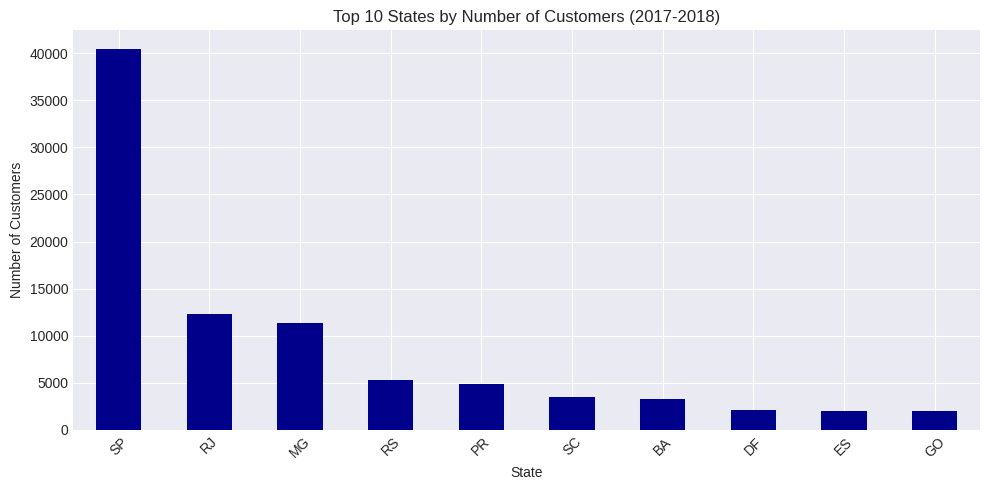

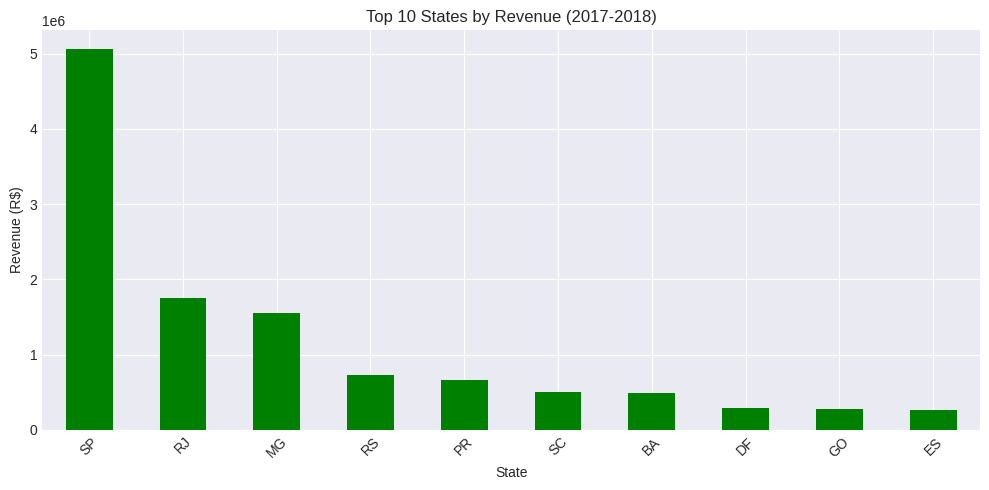

In [272]:
import matplotlib.pyplot as plt

# Bar chart for top 10 states by customers
top_cust = cust_per_state.head(10)
plt.figure(figsize=(10,5))
top_cust.plot(kind='bar', color='darkblue')
plt.title('Top 10 States by Number of Customers (2017-2018)')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar chart for top 10 states by revenue
top_rev = revenue_per_state.head(10)
plt.figure(figsize=(10,5))
top_rev.plot(kind='bar', color='green')
plt.title('Top 10 States by Revenue (2017-2018)')
plt.xlabel('State')
plt.ylabel('Revenue (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.4 Summary: Revenue per State (Jan 2017 – Aug 2018)

- **São Paulo (SP)** generates R$ 5,055,587 (38.4% of total revenue).
- **Top 5 states by revenue:** SP, RJ, MG, RS, PR – together account for ~74% of total revenue.
- Revenue concentration is slightly lower than customer concentration, suggesting customers in SP spend slightly less on average than those in RJ or MG.

**Note:** This geographic analysis uses the same time period as the revenue analysis:  
**January 2017 through August 2018** (20 complete months).  
This ensures that the customer counts and revenue figures align with the earlier findings.

## 2.5 Key Geographic Takeaways

- **São Paulo is the core market** – it holds 42% of customers and 38% of revenue. Any operational or marketing strategy must prioritise this state.
- **The Southeast region (SP, RJ, MG, ES) together accounts for ~69% of customers and ~65% of revenue** – logistics hubs should be located there.
- **Northern and Central‑West states have very low penetration** – potential growth areas, but shipping costs may be higher.
- **Recommendation:** Focus retention efforts in SP while testing low‑cost digital campaigns in under‑represented states to gauge interest.

---
## **Question 3: Product & Seller Performance Analysis**

**Business Questions:**
1. Which product categories drive the most revenue?
2. Which categories have the highest customer satisfaction?
3. Which sellers are top performers?
4. Is there a correlation between price and review score?

**Analysis Plan:**
1. Load `products`, `sellers`, and `order_reviews` datasets
2. Explore product categories (unique categories, missing values)
3. Link products to orders (using `order_items`) to calculate revenue by category
4. Link reviews to orders to calculate average review score by category
5. Identify top sellers by revenue and order count
6. Visualise key findings (bar charts, scatter plots)
7. Draw business insights
---

## 3.1 Load and Explore the Datasets

In [273]:
products_df = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
sellers_df = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")
order_reviews_df = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
print("All datasets loaded...")

All datasets loaded...


In [274]:
# Quick Exploration

print(products_df.columns)
print("----------------------------------------")
print(products_df.shape)
print("----------------------------------------")
print(products_df.head(3))
print("----------------------------------------")
print(products_df.isnull().sum())

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')
----------------------------------------
(32951, 9)
----------------------------------------
                         product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5            perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                 artes   
2  96bd76ec8810374ed1b65e291975717f         esporte_lazer   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0         

In [275]:
print(sellers_df.columns)
print("----------------------------------------")
print(sellers_df.shape)
print("----------------------------------------")
print(sellers_df.head(3))
print("----------------------------------------")
print(sellers_df.isnull().sum())

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')
----------------------------------------
(3095, 4)
----------------------------------------
                          seller_id  seller_zip_code_prefix     seller_city  \
0  3442f8959a84dea7ee197c632cb2df15                   13023        campinas   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844      mogi guacu   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031  rio de janeiro   

  seller_state  
0           SP  
1           SP  
2           RJ  
----------------------------------------
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64


In [276]:
print(order_reviews_df.columns)
print("----------------------------------------")
print(order_reviews_df.shape)
print("----------------------------------------")
print(order_reviews_df.head(3))
print("----------------------------------------")
print(order_reviews_df.isnull().sum())

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')
----------------------------------------
(99224, 7)
----------------------------------------
                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   

   review_score review_comment_title review_comment_message  \
0             4                  NaN                    NaN   
1             5                  NaN                    NaN   
2             5                  NaN                    NaN   

  review_creation_date review_answer_timestamp  
0  2018-01-18 00:00:00     2018-01-18 21:46:59  
1  2018-03-10 00:00:00     2018-03-11 03:05:13  
2  2018-02-17 00:00:00     2

### 3.1 Summary: Datasets Overview

| Dataset | Rows | Columns | Key Observations |
|---------|------|---------|------------------|
| **Products** | 32,951 | 9 | 610 missing `product_category_name` – will need handling. Physical attributes have only 2 missing rows – negligible. |
| **Sellers** | 3,095 | 4 | No missing values. Includes seller location (`seller_city`, `seller_state`) – useful for future geographic analysis. |
| **Reviews** | 99,224 | 7 | `review_score` and `order_id` are complete (0 missing). Comment fields have many missing values (expected) – not required for score analysis. |

All datasets are now ready for merging and further analysis.

## 3.2 Revenue by Product Category

Here, we will merge 'order_items_new' and 'products_df' on 'product_id'

In [277]:
print(order_items_new.columns)
print(products_df.columns)

Index(['order_id', 'price', 'product_id', 'seller_id'], dtype='object')
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')


In [278]:
# Combines order items with product metadata
items_with_cat = pd.merge(order_items_new, products_df, on = "product_id", how = 'inner')
print(items_with_cat.head(2))

                           order_id  price                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214   58.9  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  239.9  e5f2d52b802189ee658865ca93d83a8f   

                          seller_id product_category_name  \
0  48436dade18ac8b2bce089ec2a041202            cool_stuff   
1  dd7ddc04e1b6c2c614352b383efe2d36              pet_shop   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 58.0                       598.0                 4.0   
1                 56.0                       239.0                 2.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             650.0               28.0                9.0              14.0  
1           30000.0               50.0               30.0              40.0  


In [279]:
# Filters items to only those belonging to delivered orders

rev_by_cat = pd.merge(delivered_orders_1718, items_with_cat, on = "order_id", how = "inner")
print(rev_by_cat.head(2))

                           order_id order_purchase_timestamp order_status  \
0  ec7a019261fce44180373d45b442d78f      2017-01-05 11:56:06    delivered   
1  b95a0a8bd30aece4e94e81f0591249d8      2017-01-05 12:01:20    delivered   

                        customer_id year_month  year month  price  \
0  c24fc5f9a446b4d8262041b9c64de772    2017-01  2017    01   10.9   
1  ff3c6d35b4927c9b965aa6a68dcf56e4    2017-01  2017    01   10.9   

                         product_id                         seller_id  \
0  f5d8f4fbc70ca2a0038b9a0010ed5cb0  48efc9d94a9834137efd9ea76b065a38   
1  6c04a068e5ab37749c980c42a036b9e3  48efc9d94a9834137efd9ea76b065a38   

         product_category_name  product_name_lenght  \
0  fashion_bolsas_e_acessorios                 64.0   
1                   automotivo                 52.0   

   product_description_lenght  product_photos_qty  product_weight_g  \
0                      1710.0                 1.0             200.0   
1                      1367.0   

In [280]:
# Group by category
cat_revenue = (
    rev_by_cat
        .groupby('product_category_name')['price']
        .sum()
        .sort_values(ascending=False)
)

In [281]:
# Top 10 Product categories in terms of revenue
print(cat_revenue.head(10))

product_category_name
beleza_saude              1229557.50
relogios_presentes        1163465.91
cama_mesa_banho           1022955.77
esporte_lazer              952840.40
informatica_acessorios     888055.59
moveis_decoracao           706237.17
utilidades_domesticas      614341.62
cool_stuff                 609158.00
automotivo                 577838.39
ferramentas_jardim         469135.40
Name: price, dtype: float64


In [282]:
# Revenue in percentages
# Total revenue from Question 1 (delivered orders, Jan 2017 – Aug 2018)
total_revenue_q1 = 13181027.13

# Calculate percentage for each category
cat_revenue_percent = (cat_revenue / total_revenue_q1 * 100).round(2)

# Display top 10 with percentages
top10_percent = cat_revenue_percent.head(10)
print(top10_percent)

product_category_name
beleza_saude              9.33
relogios_presentes        8.83
cama_mesa_banho           7.76
esporte_lazer             7.23
informatica_acessorios    6.74
moveis_decoracao          5.36
utilidades_domesticas     4.66
cool_stuff                4.62
automotivo                4.38
ferramentas_jardim        3.56
Name: price, dtype: float64


In [283]:
# Selects rows where category is missing (NaN)
missing_cat = rev_by_cat[rev_by_cat['product_category_name'].isnull()]

In [284]:
print(f"Rows with missing category: {len(missing_cat)}")

Rows with missing category: 1535


In [285]:
print(f"Revenue from missing category: R$ {missing_cat['price'].sum():,.2f}")

Revenue from missing category: R$ 170,660.74


In [286]:
# Revenue from missing category in percentages
round(((170660.74 / 13181027.13) * 100),3)

1.295

### 3.2 Top Product Categories by Revenue (Jan 2017 – Aug 2018)

| Rank | Category | Revenue (R$) | % of Total Revenue |
|------|----------|--------------|---------------------|
| 1 | beleza_saude | 1,229,557.50 | 9.33% |
| 2 | relogios_presentes | 1,163,465.91 | 8.83% |
| 3 | cama_mesa_banho | 1,022,955.77 | 7.76% |
| 4 | esporte_lazer | 952,840.40 | 7.23% |
| 5 | informatica_acessorios | 888,055.59 | 6.74% |
| 6 | moveis_decoracao | 706,237.17 | 5.36% |
| 7 | utilidades_domesticas | 614,341.62 | 4.66% |
| 8 | cool_stuff | 609,158.00 | 4.62% |
| 9 | automotivo | 577,838.39 | 4.38% |
| 10 | ferramentas_jardim | 469,135.40 | 3.56% |

- **Missing category values:** 1,535 rows (R$ 170,660.74, ~1.3% of total revenue).  
  These rows are excluded from the ranking above – the impact is minimal.

**Observations:**  
**Observations:**  
- Health & beauty (`beleza_saude`) leads with nearly 9.3% of total revenue.  
- The top 5 categories together account for **~40%** of all revenue, showing moderate concentration.  
- Diverse categories like `cool_stuff` and `automotivo` also appear in the top 10, indicating a broad product appeal.

## 3.3 Average Review Score by Category

In [287]:
# Step 1: Get product_id for each delivered order (2017‑2018)
orders_with_items = pd.merge(delivered_orders_1718, order_items_new, on='order_id', how='inner')

# Step 2: Merge with reviews to get review scores
orders_items_reviews = pd.merge(orders_with_items, order_reviews_df, on='order_id', how='inner')

# Step 3: Now merge with products to get category names
reviews_with_cat = pd.merge(orders_items_reviews, products_df, on='product_id', how='inner')

# Now group by category and compute average review score
cat_review_mean = reviews_with_cat.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False)

In [288]:
# Show top 10 categories by average review score
print("Top 10 categories by average review score:")
print(cat_review_mean.head(10))

# Also show bottom 10
print("\nBottom 10 categories by average review score:")
print(cat_review_mean.tail(10))

Top 10 categories by average review score:
product_category_name
fashion_roupa_infanto_juvenil         5.000000
cds_dvds_musicais                     4.642857
livros_interesse_geral                4.512195
livros_importados                     4.508772
construcao_ferramentas_ferramentas    4.444444
portateis_casa_forno_e_cafe           4.438356
flores                                4.419355
livros_tecnicos                       4.393939
alimentos_bebidas                     4.369004
fashion_esporte                       4.366667
Name: review_score, dtype: float64

Bottom 10 categories by average review score:
product_category_name
artigos_de_festas                                3.833333
audio                                            3.823529
fashion_roupa_masculina                          3.780488
telefonia_fixa                                   3.754032
casa_conforto_2                                  3.629630
pc_gamer                                         3.625000
moveis_escrit

In [289]:
# count reviews per category for reliability
cat_review_count = reviews_with_cat.groupby('product_category_name')['review_score'].count().sort_values(ascending=False)
print("\nNumber of reviews per category (top 10):")
print(cat_review_count)


Number of reviews per category (top 10):
product_category_name
cama_mesa_banho                  10977
beleza_saude                      9413
esporte_lazer                     8419
moveis_decoracao                  8091
informatica_acessorios            7660
                                 ...  
cds_dvds_musicais                   14
la_cuisine                          13
pc_gamer                             8
fashion_roupa_infanto_juvenil        7
seguros_e_servicos                   2
Name: review_score, Length: 73, dtype: int64


In [290]:
# Get the top categories by average score (from earlier output)
top_cats = cat_review_mean.head(10).index

# Look up their review counts
print(cat_review_count.loc[top_cats])

product_category_name
fashion_roupa_infanto_juvenil           7
cds_dvds_musicais                      14
livros_interesse_geral                533
livros_importados                      57
construcao_ferramentas_ferramentas     99
portateis_casa_forno_e_cafe            73
flores                                 31
livros_tecnicos                       264
alimentos_bebidas                     271
fashion_esporte                        30
Name: review_score, dtype: int64


In [291]:
# Get the bottom categories by average score (from earlier output)
bottom_cats = cat_review_mean.tail(10).index

# Look up their review counts
print(cat_review_count.loc[bottom_cats])

product_category_name
artigos_de_festas                                  42
audio                                             357
fashion_roupa_masculina                           123
telefonia_fixa                                    248
casa_conforto_2                                    27
pc_gamer                                            8
moveis_escritorio                                1659
portateis_cozinha_e_preparadores_de_alimentos      14
fraldas_higiene                                    36
seguros_e_servicos                                  2
Name: review_score, dtype: int64


### 3.3 Product Categories by Average Review Score (Jan 2017 – Aug 2018)

The following tables show the ten categories with the highest average customer satisfaction scores and the ten with the lowest.  
Review counts are included to assess the reliability of each average – categories with few reviews may not represent the true customer experience.

---

### Top 10 Categories by Average Review Score

| Category | Avg Review Score | # Reviews | Reliability |
|----------|------------------|-----------|-------------|
| fashion_roupa_infanto_juvenil | 5.00 | 7 | Low (very few reviews) |
| cds_dvds_musicais | 4.64 | 14 | Low–Medium |
| livros_interesse_geral | 4.51 | 533 | **High** |
| livros_importados | 4.51 | 57 | Medium |
| construcao_ferramentas_ferramentas | 4.44 | 99 | Medium |
| portateis_casa_forno_e_cafe | 4.44 | 73 | Medium |
| flores | 4.42 | 31 | Low–Medium |
| livros_tecnicos | 4.39 | 264 | **High** |
| alimentos_bebidas | 4.37 | 271 | **High** |
| fashion_esporte | 4.37 | 30 | Low–Medium |

**Observations – Top Categories:**  
- Book-related categories (`livros_interesse_geral`, `livros_tecnicos`, `alimentos_bebidas`) consistently achieve high satisfaction with substantial review volume – they are genuine strengths.  
- The highest-scoring category (`fashion_roupa_infanto_juvenil`) has a perfect score but only 7 reviews; its result may not be representative.  
- Most top-rated categories have moderate to high review counts, giving confidence in their rankings.

---

### Bottom 10 Categories by Average Review Score

| Category | Avg Review Score | # Reviews | Reliability |
|----------|------------------|-----------|-------------|
| artigos_de_festas | 3.83 | 42 | Low–Medium |
| audio | 3.82 | 357 | **High** |
| fashion_roupa_masculina | 3.78 | 123 | Medium |
| telefonia_fixa | 3.75 | 248 | **High** |
| casa_conforto_2 | 3.63 | 27 | Low |
| pc_gamer | 3.63 | 8 | Very Low |
| moveis_escritorio | 3.52 | 1,659 | **Very High** |
| portateis_cozinha_e_preparadores_de_alimentos | 3.43 | 14 | Very Low |
| fraldas_higiene | 3.33 | 36 | Low–Medium |
| seguros_e_servicos | 2.50 | 2 | Extremely Low |

**Observations – Bottom Categories:**  
- **`moveis_escritorio`** (office furniture) stands out with a low average of 3.52 backed by **1,659 reviews** – this is a clear signal of quality or service issues that warrant investigation.  
- **Audio** (357 reviews, avg 3.82) and **telefonia_fixa** (248 reviews, avg 3.75) also show below-average satisfaction with robust data.  
- **Fashion_roupa_masculina** (123 reviews, avg 3.78) is moderately concerning.  
- Categories with very few reviews (e.g., `pc_gamer`, `seguros_e_servicos`) should be disregarded for decision-making – their scores are statistically unreliable.

---

### Key Takeaways

1. **High-performing categories** with reliable data:  
   - `livros_interesse_geral`, `livros_tecnicos`, `alimentos_bebidas` – all have both high scores and substantial reviews. These categories can be highlighted in marketing or used as benchmarks.

2. **Problem categories** with strong evidence:  
   - `moveis_escritorio` – very low score with high review count – **top priority for quality review**.  
   - `audio` and `telefonia_fixa` – moderate dissatisfaction with enough reviews to act on.

3. **Categories with insufficient data** (few reviews) should not drive business decisions, though they may be monitored for future trends.

4. **Popular categories** (like `cama_mesa_banho`, `beleza_saude`) have average scores around 4.0–4.3 (not shown) – they are not exceptional but maintain decent satisfaction given their high volume.

These insights can guide product team focus, supplier negotiations, and marketing strategies.

## 3.4 Top Seller Analysis 

### 3.4.1 Data Preparation

In [292]:
# 1. Merge delivered orders (2017–2018) with order items to get seller_id and price per item
orders_with_items = pd.merge(
    delivered_orders_1718, 
    order_items_new, 
    on='order_id', 
    how='inner'
)

In [293]:
# 2. Merge the result with sellers dataset to attach seller location (city, state)
orders_sellers = pd.merge(
    orders_with_items, 
    sellers_df, 
    on='seller_id', 
    how='inner'
)

In [294]:
# 3. Quick validation – check shape, missing values, and sample rows
print("Final dataset shape:", orders_sellers.shape)
print("\nMissing values per column:\n", orders_sellers.isnull().sum())
print("\nFirst two rows of the merged data:\n", orders_sellers.head(2))

# This dataset (orders_sellers) now contains every item sold in a delivered order
# from Jan 2017 to Aug 2018, along with seller details.
# It is the foundation for calculating seller performance metrics.

Final dataset shape: (109880, 13)

Missing values per column:
 order_id                    0
order_purchase_timestamp    0
order_status                0
customer_id                 0
year_month                  0
year                        0
month                       0
price                       0
product_id                  0
seller_id                   0
seller_zip_code_prefix      0
seller_city                 0
seller_state                0
dtype: int64

First two rows of the merged data:
                            order_id order_purchase_timestamp order_status  \
0  ec7a019261fce44180373d45b442d78f      2017-01-05 11:56:06    delivered   
1  b95a0a8bd30aece4e94e81f0591249d8      2017-01-05 12:01:20    delivered   

                        customer_id year_month  year month  price  \
0  c24fc5f9a446b4d8262041b9c64de772    2017-01  2017    01   10.9   
1  ff3c6d35b4927c9b965aa6a68dcf56e4    2017-01  2017    01   10.9   

                         product_id                      

### 3.4.2 Top Seller Analysis : Total Revenue per Seller

In [295]:
seller_revenue = orders_sellers.groupby('seller_id')['price'].sum().reset_index()
seller_revenue.columns = ['seller_id', 'total_revenue']
seller_revenue = seller_revenue.sort_values('total_revenue', ascending=False)

# View top 10
seller_revenue.head(10)

,seller_id,total_revenue
829,4869f7a5dfa277a7dca6462dcf3b52b2,226987.93
975,53243585a1d6dc2643021fd1853d8905,217940.44
853,4a3ca9315b744ce9f8e9374361493884,196882.12
2880,fa1c13f2614d7b5c4749cbc52fecda94,190917.14
1472,7c67e1448b00f6e969d365cea6b010ab,186570.05
1496,7e93a43ef30c4f03f38b393420bc753a,164582.49
2524,da8622b14eb17ae2831f4ac5b9dab84a,159816.87
1442,7a67c85e85bb2ce8582c35f2203ad736,139658.69
186,1025f0e2d44d7041d6cf58b6550e0bfa,138208.56
1747,955fee9216a65b617aa5c0531780ce60,131836.71


### 3.4.3 Top Seller Analysis : Number of orders per Seller

In [296]:
seller_orders = orders_sellers.groupby('seller_id')['order_id'].nunique().reset_index()
seller_orders.columns = ['seller_id', 'total_orders']
seller_orders = seller_orders.sort_values('total_orders', ascending=False)

# View top 10
seller_orders.head(10)

,seller_id,total_orders
1182,6560211a19b47992c3666cc44a7e94c0,1819
853,4a3ca9315b744ce9f8e9374361493884,1772
2371,cc419e0650a3c5ba77189a1882b7556a,1651
355,1f50f920176fa81dab994f9023523100,1399
2524,da8622b14eb17ae2831f4ac5b9dab84a,1311
1747,955fee9216a65b617aa5c0531780ce60,1261
1442,7a67c85e85bb2ce8582c35f2203ad736,1145
2706,ea8482cd71df3c1969d7b9473ff13abc,1132
829,4869f7a5dfa277a7dca6462dcf3b52b2,1124
708,3d871de0142ce09b7081e2b9d1733cb1,1064


### 3.4.4 Top Seller Analysis : Seller Summary

In [308]:
seller_summary = pd.merge(seller_revenue, seller_orders, on='seller_id', how='outer')
seller_summary['avg_order_value'] = seller_summary['total_revenue'] / seller_summary['total_orders']
# Round avg_order_value to two decimal places
seller_summary['avg_order_value'] = seller_summary['avg_order_value'].round(2)
seller_summary = seller_summary.sort_values('total_revenue', ascending=False)
print(seller_summary.head(10))

                             seller_id  total_revenue  total_orders  \
829   4869f7a5dfa277a7dca6462dcf3b52b2      226987.93          1124   
975   53243585a1d6dc2643021fd1853d8905      217940.44           348   
853   4a3ca9315b744ce9f8e9374361493884      196882.12          1772   
2880  fa1c13f2614d7b5c4749cbc52fecda94      190917.14           578   
1472  7c67e1448b00f6e969d365cea6b010ab      186570.05           973   
1496  7e93a43ef30c4f03f38b393420bc753a      164582.49           318   
2524  da8622b14eb17ae2831f4ac5b9dab84a      159816.87          1311   
1442  7a67c85e85bb2ce8582c35f2203ad736      139658.69          1145   
186   1025f0e2d44d7041d6cf58b6550e0bfa      138208.56           910   
1747  955fee9216a65b617aa5c0531780ce60      131836.71          1261   

      avg_order_value  
829            201.95  
975            626.27  
853            111.11  
2880           330.31  
1472           191.75  
1496           517.55  
2524           121.90  
1442           121.97  
18

### 3.4 Summary : Seller Performance Analysis

I analysed seller performance using two metrics – `total revenue` and `number of orders` – and explored whether item price influences customer satisfaction.

`Key Observations`

**Overlap Between Lists**
Four sellers appear in both the **top-10 by revenue** and **top-10 by orders**:

- `4a3ca9315b744ce9f8e9374361493884`
- `da8622b14eb17ae2831f4ac5b9dab84a`
- `7a67c85e85bb2ce8582c35f2203ad736`
- `955fee9216a65b617aa5c0531780ce60`

These sellers consistently perform well across both **value** and **volume**, making them strong candidates for:

- Promotional partnerships  
- Logistics prioritisation  
- Strategic collaborations  

---

**Different Business Models**

- **`4869f7a5dfa277a7dca6462dcf3b52b2`** ranks **#1 in revenue** but only **#9 in orders**  
  → Indicates a **premium / high-value strategy**

- **`6560211a19b47992c3666cc44a7e94c0`** ranks **#1 in orders** but does not appear among top revenue sellers  
  → Indicates a **volume / low-price strategy**

This highlights distinct seller behaviours on the platform.

---

**Concentration Patterns**

- The top revenue seller generates **over R$ 226k**
- The top order seller processes **1,772 orders**

This suggests a healthy ecosystem containing both:

- High-margin sellers  
- High-volume sellers  

---

## 3.5 Price vs. Review Score correlation

In [300]:
# Merge order_items with reviews to get price and review_score for each reviewed item
price_review = pd.merge(order_items_new, order_reviews_df, on='order_id', how='inner')

# Filter to only delivered orders from the correct period
delivered_ids = delivered_orders_1718['order_id']
price_review = price_review[price_review['order_id'].isin(delivered_ids)]

# Keep only necessary columns and drop any missing values
price_review = price_review[['price', 'review_score']].dropna()

print("Shape after merge and filter:", price_review.shape)
print(price_review.head())

Shape after merge and filter: (109696, 2)
    price  review_score
0   58.90             5
1  239.90             4
2  199.00             5
3   12.99             4
4  199.90             5


In [307]:
# Step 2: Overall correlation coefficient
corr = price_review['price'].corr(price_review['review_score'])
print(f"\nPearson correlation coefficient: {corr:.4f}")


Pearson correlation coefficient: 0.0029


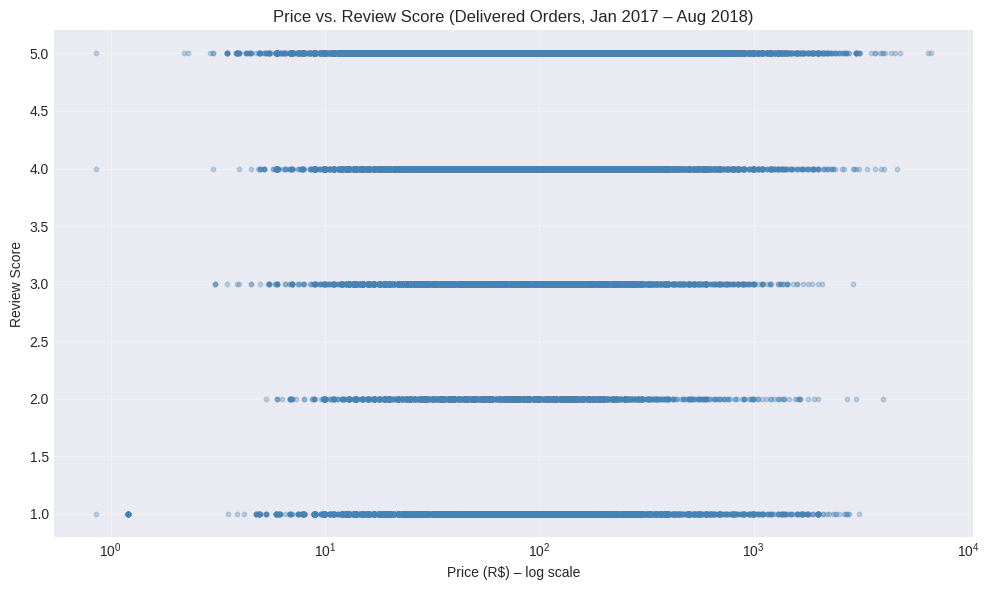

In [306]:
# Step 3: Scatter plot (log scale for price due to skew)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(price_review['price'], price_review['review_score'], 
            alpha=0.3, s=10, color='steelblue')
plt.xscale('log')
plt.xlabel('Price (R$) – log scale')
plt.ylabel('Review Score')
plt.title('Price vs. Review Score (Delivered Orders, Jan 2017 – Aug 2018)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Note on Review Granularity:**  
The `order_reviews` dataset contains one review per order, not per item. When we merged `order_items` with `reviews`, each item in a multi‑item order inherited the same review score. The scatter plot above therefore displays the same review score for every item belonging to the same order. This is acceptable for assessing the overall relationship, but individual item scores are not available.

### 3.5 Summary : Price vs. Review Score correlation

I investigated whether higher‑priced items receive better or worse customer reviews by merging `order_items` with `reviews` and filtering to delivered orders in the analysis period.

- **Pearson correlation coefficient:** **0.0029** – essentially no linear relationship.

**Interpretation & Business Implications:**
- Price is **not a driver of customer satisfaction** on Olist. Customers rate products based on factors other than cost (e.g., quality, delivery, seller service).
- The scatter plot confirms that expensive items are not systematically rated lower (or higher) than cheap ones – satisfaction is uniformly high.
- Sellers of high‑priced items need not worry that price alone will lower their ratings; they should instead focus on product quality and customer experience.


## Final Conclusion: Key Business Insights

This end‑to‑end analysis of Olist’s Brazilian e‑commerce data has uncovered three major findings:

1. **Revenue & Seasonality**  
   - Monthly revenue grew steadily throughout 2017, with a sharp peak in **November 2017** – consistent with Black Friday promotions.  
   - Revenue dipped in December but recovered strongly in 2018, reaching consistently high levels.  
   - **Recommendation:** Extend Black‑Friday‑style campaigns to other periods (e.g., mid‑year sales) and investigate the December drop to ensure operational readiness.


2. **Geographic Concentration**  
   - **São Paulo (SP)** is the dominant market, accounting for **42% of customers** and **38% of revenue**.  
   - The Southeast region (SP, RJ, MG, ES) together represents nearly 70% of the business.  
   - **Recommendation:** Focus logistics and marketing investments in the Southeast while testing low‑cost digital campaigns in under‑represented states.


3. **Product & Seller Performance**  
   - Top revenue categories: `beleza_saude`, `relogios_presentes`, `cama_mesa_banho`.  
   - **High‑satisfaction categories** with reliable data: books and food/beverages.  
   - **Problem category:** `moveis_escritorio` (office furniture) has a low average score (3.52) backed by over 1,600 reviews – this warrants a quality review.  
   - Price has **no correlation** with review scores (r ≈ 0.003); customers rate based on quality and service, not price.

These insights provide a clear roadmap for Olist to optimise marketing, improve seller quality, and enhance customer satisfaction.